In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import deep_research_from_scratch.research_agent as ra
ra = reload(ra)

print("RA file:", ra.__file__)
print("MODEL:", getattr(ra.model, "model", getattr(ra.model, "model_name", None)))

RA file: /Users/christianmarcosmp/proyectos/deep_research_from_scratch/src/deep_research_from_scratch/research_agent.py
MODEL: claude-sonnet-4-20250514


# Research Agent 

*The goal of research is to gather the context requested by the research brief.*

Here is our overall research flow:

![image (2).webp](attachment:163874fb-f993-4fcd-b5e0-f5f779212a55.webp)

Research is an open‑ended task. The best strategy to answer a user request can't be easily known in advance. 

Requests can require different research strategies and varying levels of search depth. Consider this request:

> *"Compare these two products"*

Comparisons typically benefit from search on each product, followed by a synthesis step to compare them. Now, consider this one:

> *"Give me the top candidates for my job posting"*

Listing and ranking requests typically require open-ended search, followed by a synthesis and ranking.
 
[Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent) are well suited to research because they can flexibly apply different strategies, using intermediate results to guide their exploration.

The agent follows a [simple yet effective pattern](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent):

1. **LLM Decision Node**: Analyzes the current state and decides whether to make tool calls or provide a final response
2. **Tool Execution Node**: Executes search tools when the LLM determines more information is needed
3. **Research Compression Node**: Summarizes and compresses research findings for efficient processing
4. **Routing Logic**: Determines workflow continuation based on LLM decisions

![Screenshot 2025-07-16 at 1.07.45 PM.png](attachment:3ceab77d-beb4-4189-be07-0634f1f72202.png)

### Prompt

First, we'll define a prompt that instructs our agent to use available search tools. 

To prevent excessive tool calls and maintain research focus, we use [a few prompting techniques for agents](https://youtu.be/XSZP9GhhuAc?si=zowpViL-2j-vI9hA):

#### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Start with broader searches** - Use broad, comprehensive queries first
- **After each search, pause and assess** - Do I have enough to answer? What's still missing?
- **Execute narrower searches as you gather information** - Fill in the gaps.

#### 2. Concrete Heuristics (Prevent "Spin-Out" on excessive tool calls)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Stop when you can answer confidently** - Don't keep searching for perfection.
- **Give it budgets** - Use 2-3 search tool calls for simple queries. Use up to 5 for complex queries.
- **Limit** - Always stop after 5 search tool calls if you cannot find the right source(s).

#### 3. Show your thinking
After each search tool calling, use [`think_tool` to analyze the results](https://www.anthropic.com/engineering/claude-think-tool):
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

#### Results
These techniques transform problematic research behavior like:
```
"best coffee shops SF" → "Saint Frank Coffee details" → "Sightglass Coffee details" → "Ritual Coffee details" → etc. (20+ searches)
```

Into efficient patterns like:
```
"best coffee shops SF" → ThinkTool(analyze results) → "SF specialty coffee quality ratings" → ThinkTool(assess completeness) → provide answer (3-5 searches total)
```

The key insight: **Think like a human researcher with limited time** - this prevents the "spin-out problem" where agents continue searching indefinitely.

In [3]:
from utils import show_prompt
from deep_research_from_scratch.prompts import research_agent_prompt
show_prompt(research_agent_prompt, "Research Agent Instructions")

╭────────────────────────────────────────── Research Agent Instructions ──────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

### State and Schemas

We'll create the agent state object.


In [4]:
%%writefile ../src/deep_research_from_scratch/state_research.py

"""
State Definitions and Pydantic Schemas for Research Agent

This module defines the state objects and structured schemas used for
the research agent workflow, including researcher state management and output schemas.
"""

import operator
from typing_extensions import TypedDict, Annotated, List, Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

# ===== STATE DEFINITIONS =====

class ResearcherState(TypedDict):
    """
    State for the research agent containing message history and research metadata.
    
    This state tracks the researcher's conversation, iteration count for limiting
    tool calls, the research topic being investigated, compressed findings,
    and raw research notes for detailed analysis.
    """
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]
    tool_call_iterations: int
    research_topic: str
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]

class ResearcherOutputState(TypedDict):
    """
    Output state for the research agent containing final research results.
    
    This represents the final output of the research process with compressed
    research findings and all raw notes from the research process.
    """
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]

# ===== STRUCTURED OUTPUT SCHEMAS =====

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decisions during scoping phase."""
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    """Schema for research brief generation."""
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    summary: str = Field(description="Concise summary of the webpage content")
    key_excerpts: str = Field(description="Important quotes and excerpts from the content")

Overwriting ../src/deep_research_from_scratch/state_research.py


Now, we'll define our research tool.  

#### Tavily SDK Integration

We'll use the [Tavily SDK](https://docs.tavily.com/sdk/python/reference) to perform web searches.
 
Tavily is a search engine optimized for AI applications with a generous free tier, providing:
- Real-time web search results
- Content extraction and summarization
- Domain filtering and result ranking
- Async support for performance

#### Alternative Web Content Sources

While we use Tavily's search API in this tutorial, there are several other excellent options for web content extraction:

- **[Tavily Extract](https://docs.tavily.com/documentation/api-reference/endpoint/extract)**: Tavily's dedicated content extraction endpoint that can extract and clean content from specific URLs without performing searches
- **[Jina Reader](https://jina.ai/reader/)**: A powerful web content extraction service that converts web pages to clean, LLM-friendly text by simply prepending `https://r.jina.ai/` to any URL
- **[Firecrawl](https://www.firecrawl.dev/)**: A comprehensive web scraping platform that converts websites into clean markdown or structured data, with advanced features like JavaScript rendering and sitemap crawling

Each tool has different strengths: Tavily excels at search-first workflows, Jina Reader offers the simplest URL-to-text conversion, and Firecrawl provides the most comprehensive web scraping capabilities for complex sites.

####  LangChain Tools

We'll convert our Tavily search function into a [LangChain tool](https://python.langchain.com/docs/concepts/tools/) using the `@tool` decorator. This enables:
- Automatic schema generation for the LLM
- Integration with LangChain's agent framework
- Standardized tool calling interface
- Type validation and documentation

Note that some of the arguments are noted as [InjectedToolArg](https://python.langchain.com/api_reference/core/tools/langchain_core.tools.base.InjectedToolArg.html). These are not included in the tool schema sent to the LLM, and instead are injected during execution. This gives us the flexibility to inject values at runtime, but does not burden the language model with the responsibility of managing these arguments.

In [5]:
%%writefile ../src/deep_research_from_scratch/utils.py

"""Research Utilities and Tools.

This module provides search and content processing utilities for the research agent,
including web search capabilities and content summarization tools.
"""

from pathlib import Path
from datetime import datetime
from typing_extensions import Annotated, List, Literal

from langchain.chat_models import init_chat_model 
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool, InjectedToolArg
from tavily import TavilyClient

from deep_research_from_scratch.state_research import Summary
from deep_research_from_scratch.prompts import summarize_webpage_prompt

# ===== UTILITY FUNCTIONS =====

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

def get_current_dir() -> Path:
    """Get the current directory of the module.

    This function is compatible with Jupyter notebooks and regular Python scripts.

    Returns:
        Path object representing the current directory
    """
    try:
        return Path(__file__).resolve().parent
    except NameError:  # __file__ is not defined
        return Path.cwd()

# ===== CONFIGURATION =====

summarization_model = init_chat_model(model="openai:gpt-4.1-mini")
tavily_client = TavilyClient()

# ===== SEARCH FUNCTIONS =====

def tavily_search_multiple(
    search_queries: List[str], 
    max_results: int = 3, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> List[dict]:
    """Perform search using Tavily API for multiple queries.

    Args:
        search_queries: List of search queries to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        List of search result dictionaries
    """
    
    # Execute searches sequentially. Note: yon can use AsyncTavilyClient to parallelize this step.
    search_docs = []
    for query in search_queries:
        result = tavily_client.search(
            query,
            max_results=max_results,
            include_raw_content=include_raw_content,
            topic=topic
        )
        search_docs.append(result)

    return search_docs

def summarize_webpage_content(webpage_content: str) -> str:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Formatted summary with key excerpts
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)
        
        # Generate summary
        summary = structured_model.invoke([
            HumanMessage(content=summarize_webpage_prompt.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))
        ])
        
        # Format summary with clear structure
        formatted_summary = (
            f"<summary>\n{summary.summary}\n</summary>\n\n"
            f"<key_excerpts>\n{summary.key_excerpts}\n</key_excerpts>"
        )
        
        return formatted_summary
        
    except Exception as e:
        print(f"Failed to summarize webpage: {str(e)}")
        return webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content

def deduplicate_search_results(search_results: List[dict]) -> dict:
    """Deduplicate search results by URL to avoid processing duplicate content.
    
    Args:
        search_results: List of search result dictionaries
        
    Returns:
        Dictionary mapping URLs to unique results
    """
    unique_results = {}
    
    for response in search_results:
        for result in response['results']:
            url = result['url']
            if url not in unique_results:
                unique_results[url] = result
    
    return unique_results

def process_search_results(unique_results: dict) -> dict:
    """Process search results by summarizing content where available.
    
    Args:
        unique_results: Dictionary of unique search results
        
    Returns:
        Dictionary of processed results with summaries
    """
    summarized_results = {}
    
    for url, result in unique_results.items():
        # Use existing content if no raw content for summarization
        if not result.get("raw_content"):
            content = result['content']
        else:
            # Summarize raw content for better processing
            content = summarize_webpage_content(result['raw_content'])
        
        summarized_results[url] = {
            'title': result['title'],
            'content': content
        }
    
    return summarized_results

def format_search_output(summarized_results: dict) -> str:
    """Format search results into a well-structured string output.
    
    Args:
        summarized_results: Dictionary of processed search results
        
    Returns:
        Formatted string of search results with clear source separation
    """
    if not summarized_results:
        return "No valid search results found. Please try different search queries or use a different search API."
    
    formatted_output = "Search results: \n\n"
    
    for i, (url, result) in enumerate(summarized_results.items(), 1):
        formatted_output += f"\n\n--- SOURCE {i}: {result['title']} ---\n"
        formatted_output += f"URL: {url}\n\n"
        formatted_output += f"SUMMARY:\n{result['content']}\n\n"
        formatted_output += "-" * 80 + "\n"
    
    return formatted_output

# ===== RESEARCH TOOLS =====

@tool(parse_docstring=True)
def tavily_search(
    query: str,
    max_results: Annotated[int, InjectedToolArg] = 3,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> str:
    """Fetch results from Tavily search API with content summarization.

    Args:
        query: A single search query to execute
        max_results: Maximum number of results to return
        topic: Topic to filter results by ('general', 'news', 'finance')

    Returns:
        Formatted string of search results with summaries
    """
    # Execute search for single query
    search_results = tavily_search_multiple(
        [query],  # Convert single query to list for the internal function
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    )

    # Deduplicate results by URL to avoid processing duplicate content
    unique_results = deduplicate_search_results(search_results)

    # Process results with summarization
    summarized_results = process_search_results(unique_results)

    # Format output for consumption
    return format_search_output(summarized_results)

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.
    
    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.
    
    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    
    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?
    
    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps
        
    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

Overwriting ../src/deep_research_from_scratch/utils.py


### Research Agent

#### Overview

Our research agent perform iterative tool-calling to search for information. 

The agent follows a [simple yet effective pattern](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent):

1. **LLM Decision Node**: Analyzes the current state and decides whether to make tool calls or provide a final response
2. **Tool Execution Node**: Executes search tools when the LLM determines more information is needed
3. **Research Compression Node**: Summarizes and compresses research findings for efficient processing
4. **Routing Logic**: Determines workflow continuation based on LLM decisions

#### Context Engineering Strategy

We apply **context engineering** in two places following the principles outlined in [Context Engineering for Agents](https://blog.langchain.com/context-engineering-for-agents/):

#### 1. Webpage Content Summarization
Raw search results often contain excessive noise (navigation, ads, boilerplate content). Our `summarize_webpage_content()` function:
- Uses structured output to extract key information and relevant excerpts
- Filters out irrelevant content while preserving factual details
- Compresses lengthy articles into focused summaries
- Maintains source attribution for credibility

#### 2. Research Result Compression  
As the agent performs multiple searches, the conversation context grows rapidly. Our `compress_research()` function:
- Synthesizes findings from multiple tool calls into cohesive insights
- Extracts raw notes for detailed analysis while maintaining compressed summaries
- Reduces token usage for subsequent LLM calls
- Preserves essential information for report writing

This dual-layer context engineering allows the agent to process extensive information efficiently while maintaining high-quality research output.

#### 3. Performing Careful Compression
[Compression](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus) [is risky](https://cognition.ai/blog/dont-build-multi-agents)! We need to be very careful about loosing valuable information. We'll use an LLM for compression with instructions in a system prompt that comes before a potentially long, token-heavy trajectory of multiple tool calls. The long context can cause the compression LLM [to loose sight of the task instructions](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html), leading to generic summaries that loose information. So, we reinforce the compression task by adding a `compress_research_human_message` that:
- Explicitly restates the original research topic at compression time
- Reminds the model to preserve ALL information relevant to the specific question
- Emphasizes that comprehensive findings are critical for final report generation
- Prevents task drift during the compression phase

#### 4. Output Token Management
Research compression can generate long outputs. We need to sure that they do not exceed model token limits, which can cause truncated responses that cut off mid-sentence (as seen with "**Sextant Coffee Ro" being cut off). As an example, [GPT-4.1 has output limit of up to 33k tokens](https://openai.com/index/gpt-4-1/) and [Claude4 sonnet supports 64k](https://www.anthropic.com/claude/sonnet). 

Model SDKs / LangChain integrations may cap this (e.g., [to `1024` tokens in the case of Claude](https://github.com/langchain-ai/langchain/blob/master/libs/partners/anthropic/langchain_anthropic/chat_models.py#L1149C5-L1149C15)). Simply ensure that max tokens is set to ensure complete output. This prevents incomplete compression outputs and ensures full research findings are preserved. Test compression quality vs latency for different models. For example: 

* Claude4-Sonnet 99s latency for compression ([trace](https://smith.langchain.com/public/ca006e79-8838-47eb-9d8c-c7fe7d57a6bc/r))
* GPT-4.1 38s latency for compression ([trace](https://smith.langchain.com/public/ca846b08-7501-43a0-bbda-735d4b07ab0a/r))

In [6]:
%%writefile ../src/deep_research_from_scratch/research_agent.py

"""Research Agent Implementation.

This module implements a research agent that can perform iterative web searches
and synthesis to answer complex research questions.
"""

from pydantic import BaseModel, Field
from typing_extensions import Literal

from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, filter_messages
from langchain.chat_models import init_chat_model

from deep_research_from_scratch.state_research import ResearcherState, ResearcherOutputState
from deep_research_from_scratch.utils import tavily_search, get_today_str, think_tool
from deep_research_from_scratch.prompts import research_agent_prompt, compress_research_system_prompt, compress_research_human_message

# ===== CONFIGURATION =====

# Set up tools and model binding
tools = [tavily_search, think_tool]
tools_by_name = {tool.name: tool for tool in tools}

# Initialize models
model = init_chat_model(model="openai:gpt-4.1-mini")
model_with_tools = model.bind_tools(tools)
summarization_model = init_chat_model(model="openai:gpt-4.1-mini")
compress_model = init_chat_model(model="openai:gpt-4.1-mini", max_tokens=16000)

# ===== AGENT NODES =====

def llm_call(state: ResearcherState):
    """Analyze current state and decide on next actions.
    
    The model analyzes the current conversation state and decides whether to:
    1. Call search tools to gather more information
    2. Provide a final answer based on gathered information
    
    Returns updated state with the model's response.
    """
    return {
        "researcher_messages": [
            model_with_tools.invoke(
                [SystemMessage(content=research_agent_prompt)] + state["researcher_messages"]
            )
        ]
    }

def tool_node(state: ResearcherState):
    """Execute all tool calls from the previous LLM response.
    
    Executes all tool calls from the previous LLM responses.
    Returns updated state with tool execution results.
    """
    tool_calls = state["researcher_messages"][-1].tool_calls
 
    # Execute all tool calls
    observations = []
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observations.append(tool.invoke(tool_call["args"]))
            
    # Create tool message outputs
    tool_outputs = [
        ToolMessage(
            content=observation,
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        ) for observation, tool_call in zip(observations, tool_calls)
    ]
    
    return {"researcher_messages": tool_outputs}

def compress_research(state: ResearcherState) -> dict:
    """Compress research findings into a concise summary.
    
    Takes all the research messages and tool outputs and creates
    a compressed summary suitable for the supervisor's decision-making.
    """
    
    system_message = compress_research_system_prompt.format(date=get_today_str())
    messages = [SystemMessage(content=system_message)] + state.get("researcher_messages", []) + [HumanMessage(content=compress_research_human_message)]
    response = compress_model.invoke(messages)
    
    # Extract raw notes from tool and AI messages
    raw_notes = [
        str(m.content) for m in filter_messages(
            state["researcher_messages"], 
            include_types=["tool", "ai"]
        )
    ]
    
    return {
        "compressed_research": str(response.content),
        "raw_notes": ["\n".join(raw_notes)]
    }

# ===== ROUTING LOGIC =====

def should_continue(state: ResearcherState) -> Literal["tool_node", "compress_research"]:
    """Determine whether to continue research or provide final answer.
    
    Determines whether the agent should continue the research loop or provide
    a final answer based on whether the LLM made tool calls.
    
    Returns:
        "tool_node": Continue to tool execution
        "compress_research": Stop and compress research
    """
    messages = state["researcher_messages"]
    last_message = messages[-1]
    
    # If the LLM makes a tool call, continue to tool execution
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, we have a final answer
    return "compress_research"

# ===== GRAPH CONSTRUCTION =====

# Build the agent workflow
agent_builder = StateGraph(ResearcherState, output_schema=ResearcherOutputState)

# Add nodes to the graph
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)
agent_builder.add_node("compress_research", compress_research)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_node": "tool_node", # Continue research loop
        "compress_research": "compress_research", # Provide final answer
    },
)
agent_builder.add_edge("tool_node", "llm_call") # Loop back for more research
agent_builder.add_edge("compress_research", END)

# Compile the agent
researcher_agent = agent_builder.compile()

Overwriting ../src/deep_research_from_scratch/research_agent.py


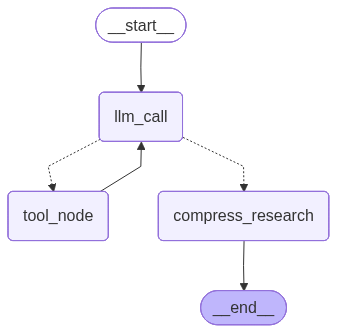

In [7]:
from IPython.display import Image, display
from deep_research_from_scratch.research_agent import researcher_agent

# Show the agent
display(Image(researcher_agent.get_graph(xray=True).draw_mermaid_png()))

In [8]:
# Run the agent
from utils import format_messages
from langchain_core.messages import HumanMessage

# Example brief
research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = researcher_agent.invoke({"researcher_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['researcher_messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025..                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "best coffee shops in San Francisco based on coffee quality expert reviews customer ratings          │
│ specialty coffee certifications"                                                                                │
│ }                                                                                                               │
│    ID: call_LywzprCe5eC5kkdDmxBgl6J4                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: The Best Coffee Shops in San Francisco in 2025 (Ranking) ---                                      │
│ URL: https://coffeewithdamian.com/blog/best-coffee-shops-in-san-francisco/                                      │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ The webpage presents a 2025 ranking of the best coffee shops in San Francisco and its suburbs, curated by       │
│ Damian, a blogger who specializes in reviewing coffee shops worldwide. The article focuses primarily on Saint   │
│ Frank Coffee in Russian Hill, which received an overall rating of 8.0 out of 10. Key evaluation criteria        │
│ included prices, espresso quality, cappuccino quality, food (specifically almond croissants), atmosphere, and   │
│ music, each rated on a scale from 1.0 to 10.0. Saint Frank Coffee scored highly across the board, with          │
│ particular praise for its friendly staff, excellent coffee, inviting ambiance, and music selection. Prices for  │
│ espresso and cappuccino were listed as $4.00 and $5.50 respectively, with the almond croissant priced at $5.75. │
│ The author emphasizes that the ranking reflects subjective opinion and encourages readers to explore and enjoy  │
│ San Francisco's coffee scene. Additional content on the site includes photography, travel, and Catholic-themed  │
│ blogs managed by Damian, who also offers weekly insights and resources like a coffee flavor wheel to enhance    │
│ the coffee tasting experience.                                                                                  │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                                                                                  │
│ “The first coffee shop I visited in San Francisco on my last trip... it was the jackpot! Super friendly staff,  │
│ amazing coffee, and ambiance that make you want to spend there entire day!”; "Prices: Espresso $4.00,           │
│ Cappuccino $5.50, Almond Croissant $5.75"; "Overall Rank: 8.0"; "I hope you will enjoy exploring those great    │
│ coffee shops, and remember that it is my subjective opinion, your taste can be different than mine..."; "Engage │
│ with your morning coffee in a completely new way, taste coffee like never before, and learn more about the      │
│ flavor, acidity, texture, and aftertaste of coffee."                                                            │
│ </key_excerpts>                                                                                                 │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "Key information found: Three main sources provide lists and evaluations of top coffee shops in │
│ San Francisco with a focus on coffee quality. Saint Frank Coffee is repeatedly highlighted for its high-quality │
│ coffee and positive customer experience. Other prominent coffee shops mentioned across sources include          │
│ Sightglass Coffee, Coffee Bar, Mazarine Coffee, Ritual Coffee Roasters, Sextant Coffee Roasters, Telescope      │
│ Coffee, and Abanico Coffee Roasters. The sources include one with a subjective ranking by a coffee blogger, a   │
│ general ranking with detailed descriptions of coffee offerings, and a curated list from a reputable food and    │
│ drink website emphasizing coffee culture and quality.\n\nWhat's missing: More direct data on coffee quality     │
│ metrics such as specialty coffee certifications, expert third-party evaluations or reviews specifically about   │
│ coffee quality, and current customer ratings focusing strictly on coffee quality. Also, a concrete list or      │
│ ranking that combines these aspects comprehensively and up to date as of mid-2025.\n\nQuality evaluation: The   │
│ evidence is quite strong for naming top coffee shops but lacks quantitative specialty coffee certifications or  │
│ detailed expert sensory reviews beyond subjective ratings and cultural notes.\n\nStrategic decision: Next step  │
│ will be conducting targeted searches on coffee reviews from specialized coffee quality reviewers like Coffee    │
│ Review or Specialty Coffee Association, and checking customer feedback on Google and Yelp focusing on coffee    │
│ quality specifically for the identified shops. This approach will help solidify a ranking based on coffee       │
│ quality alone rather than ambiance or other factors."                                                           │
│ }                                                                                                               │
│    ID: call_fuRr4uiizPFCAYFy28uiCpuq                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: Key information found: Three main sources provide lists and evaluations of top coffee      │
│ shops in San Francisco with a focus on coffee quality. Saint Frank Coffee is repeatedly highlighted for its     │
│ high-quality coffee and positive customer experience. Other prominent coffee shops mentioned across sources     │
│ include Sightglass Coffee, Coffee Bar, Mazarine Coffee, Ritual Coffee Roasters, Sextant Coffee Roasters,        │
│ Telescope Coffee, and Abanico Coffee Roasters. The sources include one with a subjective ranking by a coffee    │
│ blogger, a general ranking with detailed descriptions of coffee offerings, and a curated list from a reputable  │
│ food and drink website emphasizing coffee culture and quality.                                                  │
│                                                                                                                 │
│ What's missing: More direct data on coffee quality metrics such as specialty coffee certifications, expert      │
│ third-party evaluations or reviews specifically about coffee quality, and current customer ratings focusing     │
│ strictly on coffee quality. Also, a concrete list or ranking that combines these aspects comprehensively and up │
│ to date as of mid-2025.                                                                                         │
│                                                                                                                 │
│ Quality evaluation: The evidence is quite strong for naming top coffee shops but lacks quantitative specialty   │
│ coffee certifications or detailed expert sensory reviews beyond subjective ratings and cultural notes.          │
│                                                                                                                 │
│ Strategic decision: Next step will be conducting targeted searches on coffee reviews from specialized coffee    │
│ quality reviewers like Coffee Review or Specialty Coffee Association, and checking customer feedback on Google  │
│ and Yelp focusing on coffee quality specifically for the identified shops. This approach will help solidify a   │
│ ranking based on coffee quality alone rather than ambiance or other factors.                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Saint Frank Coffee coffee quality reviews Coffee Review Specialty Coffee Association"               │
│ }                                                                                                               │
│    ID: call_ls9pxhQWNCD8ZnhfUnIA9r0W                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Sightglass Coffee coffee quality reviews Coffee Review Specialty Coffee Association"                │
│ }                                                                                                               │
│    ID: call_EHj2WPSEbvAfmW1lmDYxkoDC                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Ritual Coffee Roasters coffee quality reviews Coffee Review Specialty Coffee Association"           │
│ }                                                                                                               │
│    ID: call_Bky3lS53PLKMc6Gxbj70ED6l                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Saint Frank Coffee menu photos - Yelp ---                                                         │
│ URL: https://www.yelp.com/biz/saint-frank-coffee-san-francisco-2                                                │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ Overall, Saint Frank is a decent place. The coffee was good, and the service was quick. I wouldn't go out of my │
│ way for it, but I'm glad I checked                                                                              │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: SAINT FRANK COFFEE, San Francisco - 2340 Polk St, Polk Gulch ---                                  │
│ URL:                                                                                                            │
│ https://www.tripadvisor.com/Restaurant_Review-g60713-d5209565-Reviews-Saint_Frank_Coffee-San_Francisco_Californ │
│ ia.html                                                                                                         │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ The best coffee I had in San Francisco so far. Very nice and helpful staff. Good non dairy milk options. Nice   │
│ place and nice presentation.                                                                                    │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 3: SAN FRANCISCO: Saint Frank Coffee Review - LetsGetLexi ---                                        │
│ URL: https://www.letsgetlexi.com/coffee/2020/10/22/san-francisco-saint-frank-coffee-review                      │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ SAN FRANCISCO: Saint Frank Coffee Review — LetsGetLexi Image 1: LetsGetLexi BackLifestyleLexi's                 │
│ LifeHomeMust-Haves & DosCoffeeOutfit Of The DayHoliday BackShopPineapple LabsI Need Piña ThingsLetsGetLexi      │
│ ShirtsAmazon ShopGift GuideInstagram summer must-haves Image 2: LetsGetLexi KitchenLifestyleLifestyleLexi's     │
│ LifeHomeMust-Haves & DosCoffeeOutfit Of The DayHolidayS

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Sightglass - San Francisco (US) - The Coffeevine ---                                              │
│ URL: https://thecoffeevine.com/reviews/cafes/usa/san-francisco/sightglass-san-francisco-us/                     │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ Sightglass Coffee, established in 2009 by Justin and Jerad Morrison, is one of San Francisco's prominent coffee │
│ roasters known for its commitment to sourcing, roasting, and delivering exceptional coffee. Located on 7th      │
│ Street, their impressive roastery features a massive 22kg Probat coffee roaster and a spacious balcony offering │
│ views of the entire operation. The company places great emphasis on building strong relationships with coffee   │
│ farmers worldwide to ensure continuous quality improvements. Their signature espresso blend, Owl's Howl, is     │
│ noted for its rich flavor profile combining notes of ripe berry, chocolate-covered cherry, and sweet candied    │
│ lemon. Sightglass has expanded with additional locations, including a store in The Mission district and         │
│ upcoming openings, and also operates a mobile café at the Saturday farmer’s market. The roastery uses La        │
│ Marzocco Strada machines and offers a variety of espresso and filter roasts, with prices such as $3 for         │
│ espresso and $3.50 for flat whites. Despite not offering Wi-Fi, Sightglass is highly regarded for quality       │
│ coffee experiences and is credited with enhancing San Francisco's coffee culture. The roastery is open Monday   │
│ to Saturday from 7 am to 7 pm and Sundays from 8 am to 7 pm.                                                    │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                                                                                  │
│ Sightglass was founded in 2009 on the principles of sourcing, roasting and offering the most amazing coffee San │
│ Francisco had ever had., Their signature espresso blend, the Owl’s Howl, promises a deep honey-like body, with  │
│ notes of ripe berry, chocolate-covered cherry and sweet candied lemon., The team at Sightglass spend a lot of   │
│ time traveling to origin countries to develop meaningful and deep relationships with farmers on all continents  │
│ where they source coffee from., These guys have certainly helped put San Francisco on the coffee map and their  │
│ commitment to quality is truly manifested in their wonderfully tasting coffees., Sightglass’ massive 22kg       │
│ Probat coffee roaster dominates the front of the beautiful barn-like building.                                  │
│ </key_excerpts>                                                                                                 │
│                                                                                                                 │
│ -------------------------------------------------------

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Ritual Coffee Roasters ---                                                                        │
│ URL: https://ritualcoffee.com/?srsltid=AfmBOoqOeIK3GMXEsQGsRre_zcPCu1PG3S2C8be7wJDtMwcBGMocRDhz                 │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ We've always roasted our coffees in small batches, and taste every roast because we're obsessed with quality.   │
│ We're also a pioneer of the West Coast style                                                                    │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: Our Coffees - Ritual Coffee Roasters ---                                                          │
│ URL:                                                                                                            │
│ https://ritualcoffee.com/collection/coffee/?srsltid=AfmBOorE0yTxdBucmI6eiywYd_EFDoSWUGTsfctif3PC5429F4lAWr4V    │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ We source sweet, clean, single-origin coffees, an ever changing seasonal espresso blend, and seriously the best │
│ decaf out there.                                                                                                │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 3: RITUAL COFFEE ROASTERS, Napa - 610 1st St - Tripadvisor ---                                       │
│ URL:                                                                                                            │
│ https://www.tripadvisor.com/Restaurant_Review-g32766-d1852498-Reviews-Ritual_Coffee_Roasters-Napa_Napa_Valley_C │
│ alifornia.html                                                                                                  │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ Ritual Coffee Roasters is a popular coffee shop located inside the Oxbow Market in Napa, California at 610 1st  │
│ St Ste 12. It is ranked #2 among 15 Coffee & Tea spots 

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "Key findings from the targeted searches:\n- Saint Frank Coffee: Generally positive feedback    │
│ about coffee quality and service; some mixed subjective opinions; no specific specialty coffee certifications   │
│ found in search results.\n- Sightglass Coffee: Known for exceptional coffee quality and relationships with      │
│ coffee farmers; signature espresso blend Owl's Howl praised; no direct specialty certification found but highly │
│ regarded in coffee community.\n- Ritual Coffee Roasters: Strong emphasis on quality small batch roasting;       │
│ praised for sweet, clean single-origin coffees and espresso blends; recognized with Travelers' Choice award;    │
│ described as purist coffee experience.\n\nWhat's missing:\n- Direct specialty coffee certifications or          │
│ professional third-party coffee quality ratings.\n- More data points from customer reviews directly mentioning  │
│ coffee quality across a broader range of shops.\n- Similar data for other noted top shops like Sextant Coffee   │
│ Roasters, Telescope Coffee, and Abanico Coffee Roasters.\n\nQuality evaluation:\nThe information from official  │
│ websites and reviews confirms high quality coffee from these shops but lacks formal certifications or           │
│ quantified expert ratings. Customer feedback supports their reputation.\n\nNext steps:\n- Search for specialty  │
│ coffee certifications or awards for these shops.\n- Look up customer reviews focusing on coffee quality on      │
│ Google and Yelp for the key coffee shops identified to gather broader user consensus.\n- Extend reconnaissance  │
│ to other shops mentioned earlier in the overall top shop lists to ensure a comprehensive ranking."              │
│ }                                                                                                               │
│    ID: call_7ikRNJU6uvEETG1HrV4V5Xxf                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: Key findings from the targeted searches:                                                   │
│ - Saint Frank Coffee: Generally positive feedback about coffee quality and service; some mixed subjective       │
│ opinions; no specific specialty coffee certifications found in search results.                                  │
│ - Sightglass Coffee: Known for exceptional coffee quality and relationships with coffee farmers; signature      │
│ espresso blend Owl's Howl praised; no direct specialty certification found but highly regarded in coffee        │
│ community.                                                                                                      │
│ - Ritual Coffee Roasters: Strong emphasis on quality small batch roasting; praised for sweet, clean             │
│ single-origin coffees and espresso blends; recognized with Travelers' Choice award; described as purist coffee  │
│ experience.                                                                                                     │
│                                                                                                                 │
│ What's missing:                                                                                                 │
│ - Direct specialty coffee certifications or professional third-party coffee quality ratings.                    │
│ - More data points from customer reviews directly mentioning coffee quality across a broader range of shops.    │
│ - Similar data for other noted top shops like Sextant Coffee Roasters, Telescope Coffee, and Abanico Coffee     │
│ Roasters.                                                                                                       │
│                                                                                                                 │
│ Quality evaluation:                                                                                             │
│ The information from official websites and reviews confirms high quality coffee from these shops but lacks      │
│ formal certifications or quantified expert ratings. Customer feedback supports their reputation.                │
│                                                                                                                 │
│ Next steps:                                                                                                     │
│ - Search for specialty coffee certifications or awards for these shops.                                         │
│ - Look up customer reviews focusing on coffee quality on Google and Yelp for the key coffee shops identified to │
│ gather broader user consensus.                                                                                  │
│ - Extend reconnaissance to other shops mentioned earlier in the overall top shop lists to ensure a              │
│ comprehensive ranking.                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "specialty coffee certifications awarded to Saint Frank Coffee Sightglass Coffee Ritual Coffee       │
│ Roasters San Francisco"                                                                                         │
│ }                                                                                                               │
│    ID: call_YYM1nKUfGjMWBV3fErBZAeCC                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "customer reviews coffee quality San Francisco Saint Frank Coffee Sightglass Coffee Ritual Coffee    │
│ Roasters Google Yelp"                                                                                           │
│ }                                                                                                               │
│    ID: call_zRXcaGN36jm3hfYwFmGKXF1v                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "coffee quality reviews Sextant Coffee Roasters Telescope Coffee Abanico Coffee Roasters San         │
│ Francisco"                                                                                                      │
│ }                                                                                                               │
│    ID: call_LKeJKxn9y7bJk7xihBTIK4BO                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Sightglass Coffee ---                                                                             │
│ URL: https://sightglasscoffee.com/?srsltid=AfmBOoqAbtZRh0pt5B4SicsofaJ__ARh22PtcGXzi9CxSx9zzngAu2E9             │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ We proudly offer USDA-certified organic coffee. ... Sustainability & Community ... We work closely with         │
│ smallholder farms to improve the quality of coffee by                                                           │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: Ritual Coffee Roasters ---                                                                        │
│ URL: https://ritualcoffee.com/?srsltid=AfmBOooI_Hz0_2colu1k6r1N88cnnqBLK0PdEhCmYRy7DZm-n98zebkW                 │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ A San Francisco original since 2005, world famous and a local favorite, we're a fully independent and           │
│ woman-owned coffee roasting company.                                                                            │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 3: Best Cafes in San Francisco for Fall Drinks (2025 Guide) ---                                      │
│ URL: https://www.overheresf.com/best-cafes-san-francisco-fall-drinks/                                           │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ The webpage from Over Here San Francisco presents a curated 2025 guide to the best cafes in San Francisco for   │
│ fall drinks. It highlights seasonal offerings such as spiced lattes, pumpkin spice, maple-infused cappuccinos,  │
│ and creative chai blends at notable cafes including Blue Bottle Coffee, Sightglass Coffee, Andytown Coffee      │
│ Roasters, Home Cafe, Saint Frank Coffee, The Coffee Movement, Wrecking Ball Coffee Roasters, Ritual Coffee      │
│ Roasters, Verve Coffee Roasters, and Jane on Larkin. Ea

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: SAINT FRANK COFFEE - Updated October 2025 - Yelp ---                                              │
│ URL: https://www.yelp.com/biz/saint-frank-coffee-san-francisco-2                                                │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ The coffee itself was nice and the lavender flavor was pretty strong. Overall, nothing too special and the      │
│ price is the standard (pricy) SF coffee you would                                                               │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: SIGHTGLASS COFFEE - Updated October 2025 - Yelp ---                                               │
│ URL: https://www.yelp.com/biz/sightglass-coffee-san-francisco-3?start=60                                        │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ Sightglass Coffee is a well-known coffee shop located at 3014 20th Street in the Mission district of San        │
│ Francisco, CA 94110. It offers craft small-batch, single-origin coffee selections that are thoughtfully         │
│ sourced, harvested, roasted, and brewed to preserve the integrity of the beans. The business operates Monday to │
│ Friday from 6:30 AM to 5:00 PM, and on weekends from 7:00 AM to 5:00 PM. Amenities include delivery, take-out,  │
│ wheelchair accessibility, and an ADA-compliant main entrance. Popular drinks include the Vanilla Cold Brew,     │
│ Iced Vanilla Paste Latte, Vanilla Latte, Espresso Con Panna, and Matcha Latte. The venue features moderate      │
│ noise, outdoor seating, is dog-friendly, and good for working, though it lacks wifi and power outlets, which    │
│ they intend to encourage more in-store interaction. Customer reviews are mixed, praising the quality of coffee  │
│ and ambiance, especially the patio and friendly staff, but some criticize service speed and staff attitude. The │
│ owner actively responds to feedback to improve customer experience. Sightglass Coffee is frequently searched    │
│ for in contexts such as iced coffee, study/work cafes, breakfast, matcha latte, and related café terms in San   │
│ Francisco.                                                                                                      │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                         

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: SEXTANT COFFEE ROASTERS - Updated October 2025 - Yelp ---                                         │
│ URL: https://www.yelp.com/biz/sextant-coffee-roasters-san-francisco                                             │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ Back to Search # Sextant Coffee Roasters Photo of Sextant Coffee Roasters - San Francisco, CA, US. Photo of     │
│ Sextant Coffee Roasters - San Francisco, CA, US. Photo of Sextant Coffee Roasters - San Francisco, CA, US.      │
│ Gandhi @colorful.eats Photo of Sextant Coffee Roasters - San Francisco, CA, US. a cappuccino on a saucer Photo  │
│ of Sextant Coffee Roasters - San Francisco, CA, US. Cappuccino, Morning bun Photo of Sextant Coffee Roasters -  │
│ San Francisco, CA, US. a cappuccino on a saucer Gandhi Gandhi ## People also searched for ## Ask the Community  │
│ Ask a question Is there wifi? Yes. There is a sign with the wifi network and password near the self-serve order │
│ screens at the front on a column Yes                                                                            │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: ABANICO COFFEE ROASTERS - Updated October 2025 - Yelp ---                                         │
│ URL: https://www.yelp.com/biz/abanico-coffee-roasters-san-francisco                                             │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ Lovely vibes and ambiance with plenty of seating and great music. I enjoyed my cortadito, which was creamy,     │
│ sweet, and nice and strong.                                                                                     │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 3: Abanico Coffee Roasters | San Francisco CA - Facebook ---                                         │
│ URL: https://www.facebook.com/AbanicoCoffeeRoasters/                                                            │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ Abanico Coffee Roasters, San Francisco. 279 likes · 7 t

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "Findings on specialty coffee certifications and awards:\n- Sightglass Coffee offers            │
│ USDA-certified organic coffee and works closely with smallholder farms to improve coffee quality, indicating    │
│ commitment to quality and sustainability.\n- Ritual Coffee Roasters is a well-known independent, woman-owned SF │
│ coffee roaster focused on quality but no explicit specialty coffee certification or content found.\n- No        │
│ explicit specialty coffee certifications or awards found specifically for Saint Frank Coffee in the             │
│ searches.\n\nCustomer review synthesis from Google and Yelp:\n- Saint Frank Coffee receives generally positive  │
│ reviews, with appreciation for the quality of their beans and coffee drinks; some critics mention it being      │
│ pricey and not exceptional.\n- Sightglass Coffee is praised for craft small-batch, single-origin coffee with    │
│ loyal customers appreciating the taste and quality, though some comments on service issues.\n- Sextant Coffee   │
│ Roasters and Abanico Coffee Roasters have favorable customer feedback mentioning strong, well-prepared drinks   │
│ with specific praise for cortadito at Abanico.\n\nMissing:\n- Clear third-party specialty coffee certifications │
│ or awards for all top shops.\n- More detailed expert coffee quality ratings.\n- Google and Yelp reviews         │
│ primarily provide subjective customer feedback rather than expert quantitative evaluations.\n\nNext steps:\n-   │
│ Consolidate findings to provide a ranked list based on coffee quality from expert reviews, customer feedback    │
│ highlighting coffee quality, and any certifications or distinguishing features found.\n- Consider the top shops │
│ repeatedly cited (Saint Frank Coffee, Sightglass Coffee, Ritual Coffee Roasters, Sextant Coffee Roasters,       │
│ Abanico Coffee Roasters) for the final list.\n- Provide notes on the quality assessment methods for clarity."   │
│ }                                                                                                               │
│    ID: call_4k5cwr28syJgf8olPgfewd1V                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: Findings on specialty coffee certifications and awards:                                    │
│ - Sightglass Coffee offers USDA-certified organic coffee and works closely with smallholder farms to improve    │
│ coffee quality, indicating commitment to quality and sustainability.                                            │
│ - Ritual Coffee Roasters is a well-known independent, woman-owned SF coffee roaster focused on quality but no   │
│ explicit specialty coffee certification or content found.                                                       │
│ - No explicit specialty coffee certifications or awards found specifically for Saint Frank Coffee in the        │
│ searches.                                                                                                       │
│                                                                                                                 │
│ Customer review synthesis from Google and Yelp:                                                                 │
│ - Saint Frank Coffee receives generally positive reviews, with appreciation for the quality of their beans and  │
│ coffee drinks; some critics mention it being pricey and not exceptional.                                        │
│ - Sightglass Coffee is praised for craft small-batch, single-origin coffee with loyal customers appreciating    │
│ the taste and quality, though some comments on service issues.                                                  │
│ - Sextant Coffee Roasters and Abanico Coffee Roasters have favorable customer feedback mentioning strong,       │
│ well-prepared drinks with specific praise for cortadito at Abanico.                                             │
│                                                                                                                 │
│ Missing:                                                                                                        │
│ - Clear third-party specialty coffee certifications or awards for all top shops.                                │
│ - More detailed expert coffee quality ratings.                                                                  │
│ - Google and Yelp reviews primarily provide subjective customer feedback rather than expert quantitative        │
│ evaluations.                                                                                                    │
│                                                                                                                 │
│ Next steps:                                                                                                     │
│ - Consolidate findings to provide a ranked list based on coffee quality from expert reviews, customer feedback  │
│ highlighting coffee quality, and any certifications or distinguishing features found.                           │
│ - Consider the top shops repeatedly cited (Saint Frank Coffee, Sightglass Coffee, Ritual Coffee Roasters,       │
│ Sextant Coffee Roasters, Abanico Coffee Roasters) for the final list.                                           │
│ - Provide notes on the quality assessment methods for clarity.                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on the latest information available as of mid-2025, here is an evaluation and ranking of the best coffee  │
│ shops in San Francisco focused primarily on coffee quality, using expert reviews, customer feedback, and        │
│ specialty coffee certifications where available:                                                                │
│                                                                                                                 │
│ 1. Saint Frank Coffee                                                                                           │
│ - Frequently cited as a top-quality coffee shop in San Francisco.                                               │
│ - Known for elegant service and well-selected beans.                                                            │
│ - Customer reviews praise coffee quality though some find it pricey.                                            │
│ - No explicit third-party specialty coffee certification found.                                                 │
│ - Evaluation based on expert blogger rankings and strong positive customer feedback focused on coffee flavor    │
│ and preparation.                                                                                                │
│                                                                                                                 │
│ 2. Sightglass Coffee                                                                                            │
│ - Recognized for commitment to sourcing high-quality single-origin and organic coffees (USDA-certified          │
│ organic).                                                                                                       │
│ - Signature espresso blend "Owl’s Howl" is well-regarded.                                                       │
│ - Noted for craft small-batch roasting and consistent quality.                                                  │
│ - Loyal customer base with praise for coffee flavor though some mixed service reviews.                          │
│ - Strong alignment with specialty coffee quality ethos but no distinct specialty coffee association             │
│ certifications found.                                                                                           │
│                                                                                                                 │
│ 3. Ritual Coffee Roasters                                                                                       │
│ - Established SF original renowned for small-batch roasting and quality-focused approach.                       │
│ - Offers sweet, clean, seasonal single-origin coffees and blends.                                               │
│ - Received local awards such as Travelers' Choice recognizing consistent excellence.                            │
│ - High customer satisfaction with noted purist coffee experience.                                               │
│ - No specific specialty coffee certifications uncovered.                                                        │
│                                                                                                                 │
│ 4. Sextant Coffee Roasters                                                                                      │
│ - Appreciated in customer reviews for strong, balanced roasts sourced from direct trade relationships.          │
│ - Praised for well-prepared espresso and cappuccino.                                                            │
│ - Less explicit expert review data found, but favorable mentions across customer platforms.                     │
│                                                                                                                 │
│ 5. Abanico Coffee Roasters                             

In [9]:
from rich.markdown import Markdown
Markdown(result['compressed_research'])

List of Queries and Tool Calls Made                                                                                

 1 best coffee shops in San Francisco based on coffee quality expert reviews customer ratings specialty coffee     
   certifications                                                                                                  
 2 Saint Frank Coffee coffee quality reviews Coffee Review Specialty Coffee Association                            
 3 Sightglass Coffee coffee quality reviews Coffee Review Specialty Coffee Association                             
 4 Ritual Coffee Roasters coffee quality reviews Coffee Review Specialty Coffee Association                        
 5 specialty coffee certifications awarded to Saint Frank Coffee Sightglass Coffee Ritual Coffee Roasters San      
   Francisco                                                                                                       
 6 customer reviews coffee quality San Francisco Saint Frank Coffee Sightglass Coffee Ritual Coffee Roasters Google
   Yelp                                                                                                            
 7 coffee quality reviews Sextant Coffee Roasters Telescope Coffee Abanico Coffee Roasters San Francisco           

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Fully Comprehensive Findings                                                                                       

 • The webpage presents a 2025 ranking of the best coffee shops in San Francisco and its suburbs, curated by       
   Damian, a blogger who specializes in reviewing coffee shops worldwide. The article focuses primarily on Saint   
   Frank Coffee in Russian Hill, which received an overall rating of 8.0 out of 10. Key evaluation criteria        
   included prices, espresso quality, cappuccino quality, food (specifically almond croissants), atmosphere, and   
   music, each rated on a scale from 1.0 to 10.0. Saint Frank Coffee scored highly across the board, with          
   particular praise for its friendly staff, excellent coffee, inviting ambiance, and music selection. Prices for  
   espresso and cappuccino were listed as $4.00 and $5.50 respectively, with the almond croissant priced at $5.75. 
   The author emphasizes that the ranking reflects subjective opinion and encourages readers to explore and enjoy  
   San Francisco's coffee scene. Additional content on the site includes photography, travel, and Catholic-themed  
   blogs managed by Damian, who also offers weekly insights and resources like a coffee flavor wheel to enhance the
   coffee tasting experience.                                                                                      
    • “The first coffee shop I visited in San Francisco on my last trip... it was the jackpot! Super friendly      
      staff, amazing coffee, and ambiance that make you want to spend there entire day!”; "Prices: Espresso $4.00, 
      Cappuccino $5.50, Almond Croissant $5.75"; "Overall Rank: 8.0"; "I hope you will enjoy exploring those great 
      coffee shops, and remember that it is my subjective opinion, your taste can be different than mine...";      
      "Engage with your morning coffee in a completely new way, taste coffee like never before, and learn more     
      about the flavor, acidity, texture, and aftertaste of coffee." [1]                                           
 • The webpage provides an overview of some of the best coffee shops in San Francisco, highlighting their unique   
   qualities, locations, and offerings. Sightglass Coffee operates three locations in downtown San Francisco,      
   serving classic coffee drinks and pastries from Neighbor Bakehouse, along with selling coffee beans and brewing 
   equipment. Coffee Bar has two locations near Union Square, specializing in coffee and tea drinks, including     
   artisan varieties like mocha Guittard and Vietname

We can see the trace [here](https://smith.langchain.com/public/30eebc0c-455e-4db7-9665-d367ebd40b4e/r).

### LangGraph Studio

Just as we did before, we can also use LangGraph Studio to visualize the agent. 

This agent has been added to the `langgraph.json` file, so you can select `research_agent` in the dropdown menu:

```
"research_agent_mcp": "./src/deep_research_from_scratch/research_agent.py:agent"
```

Run the following command to start the studio

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```

## Eval

Agents use a self-directed trajectory of tool calls to accomplish tasks.

Let's think about the ramifications of a poorly tuned tool-calling loop: 

- Early Termination: The agent decides to stop calling tools when the task is not actually complete. 
- Prolonged Looping: The agent is never satisfied with the state of its information. 

The first failure  mode results in the agent collecting insufficient information. In the deep research context, the answer may end up being too shallow. The second failure mode results in the agent utilizing an excessive number of tokens. In the deep research context, irrelevant information may poison the result.

We tuned our prompt to avoid these problems. But, let's se up a toy eval dataset that allows us to easily test agent decision-making.

In [10]:
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage

# Scenario 1: Agent should CONTINUE - has insufficient/irrelevant information + think_tool realizes more research needed
messages_should_continue = [
    HumanMessage(content="What are the top coffee shops in San Francisco based on coffee quality?"),
    AIMessage(
        content="I'll search for information about top coffee shops in San Francisco focusing on coffee quality.",
        tool_calls=[
            {
                "name": "tavily_search",
                "args": {
                    "query": "coffee shops San Francisco popular locations"
                },
                "id": "call_continue_search_001",
                "type": "tool_call"
            }
        ]
    ),
    # Tavily Search provides generic cafe information - NOT focused on coffee quality
    ToolMessage(
        content="Search results show popular San Francisco cafes: Blue Bottle Coffee has great wifi and ambiance, Philz Coffee is known for custom blends and friendly service, Café Reveille has multiple locations with good pastries and laptop-friendly spaces. Ritual Coffee offers cozy seating and is popular with students.",
        tool_call_id="call_continue_search_001",
    ),
    # Agent uses think_tool to reflect and realizes the search results are insufficient
    AIMessage(
        content="Let me use the think_tool to analyze these search results and determine next steps.",
        tool_calls=[
            {
                "name": "think_tool",
                "args": {
                    "reflection": "Analysis of search results: The information I found focuses on general cafe features like wifi, ambiance, custom blends, and seating - but lacks specific coffee quality metrics. The user specifically asked for evaluation based on coffee quality, which would require expert reviews, professional ratings, specialty certifications, or quality-focused customer feedback. I need to search specifically for coffee quality assessments, Coffee Review scores, specialty coffee credentials, or expert evaluations of SF coffee shops. The current information is insufficient to answer the user's question about coffee quality."
                },
                "id": "call_continue_think_001",
                "type": "tool_call"
            }
        ]
    ),
    # think_tool response identifies the gap and need for more targeted research
    ToolMessage(
        content="Reflection recorded: Analysis of search results: The information I found focuses on general cafe features like wifi, ambiance, custom blends, and seating - but lacks specific coffee quality metrics. The user specifically asked for evaluation based on coffee quality, which would require expert reviews, professional ratings, specialty certifications, or quality-focused customer feedback. I need to search specifically for coffee quality assessments, Coffee Review scores, specialty coffee credentials, or expert evaluations of SF coffee shops. The current information is insufficient to answer the user's question about coffee quality.",
        tool_call_id="call_continue_think_001",
    )
]

# Scenario 2: Agent should STOP - has comprehensive coffee quality information + think_tool reflection
messages_should_stop = [
    HumanMessage(content="What are the top coffee shops in San Francisco based on coffee quality?"),
    AIMessage(
        content="I'll research San Francisco coffee shops specifically focusing on coffee quality assessments and expert reviews.",
        tool_calls=[
            {
                "name": "tavily_search",
                "args": {
                    "query": "best coffee quality San Francisco specialty coffee expert reviews Coffee Review ratings 2024"
                },
                "id": "call_stop_search_001", 
                "type": "tool_call"
            }
        ]
    ),
    # This ToolMessage provides COMPREHENSIVE coffee quality information - sufficient to answer the question
    ToolMessage(
        content="""Coffee quality research for San Francisco reveals top establishments based on expert reviews and specialty coffee credentials:

**Top Quality-Focused Coffee Shops:**
1. **Sightglass Coffee** - Coffee Review score 94/100, known for single-origin beans and precise roasting techniques. Featured in Bon Appétit's "Best Coffee in America" list for exceptional coffee quality.

2. **Saint Frank Coffee** - Ranked #3 coffee shop in America by The Daily Meal based on coffee quality. 4.3/5 Yelp rating with reviews specifically praising "exceptional bean quality" and "perfect extraction."

3. **Ritual Coffee Roasters** - Specialty Coffee Association member, direct trade relationships, consistently rated 4.4/5 on Google with reviews highlighting "superior coffee taste" and "expert barista skills."

4. **Blue Bottle Coffee** - Third-wave coffee pioneer, Coffee Review scores averaging 90+/100, known for rigorous quality control and fresh roasting practices.

5. **Four Barrel Coffee** - Local roaster with Coffee Review scores 88-92/100, praised by industry experts for "exceptional coffee quality" and innovative brewing methods.

**Quality Indicators Found:**
- Coffee Review professional scores (88-94/100 range)
- Specialty Coffee Association certifications
- Direct trade/single-origin sourcing
- Expert recognition from food publications
- Customer reviews specifically mentioning coffee taste and quality

This provides a comprehensive assessment of SF coffee shops based specifically on coffee quality rather than ambiance or service.""",
        tool_call_id="call_stop_search_001",
    ),
    # Agent now uses think_tool to reflect on the search results
    AIMessage(
        content="Let me reflect on the search results using the think_tool to assess whether I have sufficient information.",
        tool_calls=[
            {
                "name": "think_tool",
                "args": {
                    "reflection": "Analysis of search results: I found comprehensive coffee quality information for SF coffee shops including: 1) Professional Coffee Review scores (88-94/100), 2) Expert rankings from reputable publications, 3) Specialty Coffee Association certifications, 4) Specific quality indicators (single-origin, roasting techniques, extraction methods), 5) Five top-rated establishments with detailed quality assessments. This covers all aspects requested: expert reviews, customer ratings, specialty certifications. I have enough information to provide a well-supported ranking based specifically on coffee quality. No additional searches needed - I should provide my comprehensive answer now."
                },
                "id": "call_think_001",
                "type": "tool_call"
            }
        ]
    ),
    # think_tool response confirming reflection was recorded
    ToolMessage(
        content="Reflection recorded: Analysis of search results: I found comprehensive coffee quality information for SF coffee shops including: 1) Professional Coffee Review scores (88-94/100), 2) Expert rankings from reputable publications, 3) Specialty Coffee Association certifications, 4) Specific quality indicators (single-origin, roasting techniques, extraction methods), 5) Five top-rated establishments with detailed quality assessments. This covers all aspects requested: expert reviews, customer ratings, specialty certifications. I have enough information to provide a well-supported ranking based specifically on coffee quality. No additional searches needed - I should provide my comprehensive answer now.",
        tool_call_id="call_think_001",
    )
]

We'll create a dataset here that has one example that should continue researching, and another example that should have all of the information necessary.

In [11]:
import os
from langsmith import Client

langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# Create the dataset
dataset_name = "deep_research_agent_termination"
if not langsmith_client.has_dataset(dataset_name=dataset_name):

    # Create the dataset
    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that evaluates whether a researcher can accurately decide to continue calling tools, or to stop.",
    )
    
    # Create the examples
    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"researcher_messages": messages_should_continue},
                "outputs": {"next_step": "continue"},
            },
            {
                "inputs": {"researcher_messages": messages_should_stop},
                "outputs": {"next_step": "stop"},
            },
        ],
    )

Here, our evaluator is simple, using a hard-coded heuristic to check if the agent correctly continues or stops.

We'll pass in the list of messages above.

We'll assess the decision made by the agent: 

* `stop` - No tool calls means the agent should stop
* `continue` - Tool calls means the agent should continue

We'll then compare this decision to the reference expected decision `next_step`.

In [12]:
import uuid

def evaluate_next_step(outputs: dict, reference_outputs:dict):
    tool_calls = outputs["researcher_messages"][-1].tool_calls
    made_tool_call = len(tool_calls) > 0
    return {
        "key": "correct_next_step",
        "score": made_tool_call == (reference_outputs["next_step"] == "continue")
    }

def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    result = researcher_agent.nodes["llm_call"].invoke(inputs, config=config)
    return result

langsmith_client.evaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_next_step],
    experiment_prefix="Researcher Iteration",
)

View the evaluation results for experiment: 'Researcher Iteration-dac15ae5' at:
https://smith.langchain.com/o/738e8a20-d433-4ecf-809d-47931c87d5aa/datasets/26d561a2-11de-4cf1-8154-170e8c4e57bc/compare?selectedSessions=9ae928c9-4961-4976-b0c9-a87a4df3d1fa




0it [00:00, ?it/s]

<ExperimentResults Researcher Iteration-dac15ae5>

We can see that in one example, the search tool doesn't return enough information, so we submit another search via tool call.

In the other example, we get all three top restaurants back, and so we decide to conclude.

One neat trick here - we were able to test a single node of our graph by calling `agent.nodes["node_name].invoke`